# Trabalho #3 - Trabalho Final da Disciplina

## Equipe:
- João Lucas Lima Monteiro - 473521

- Caio Martim Barros - 472713

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import time

sns.set(style='darkgrid', font_scale=0.5)
custom_palette = ['#8b4513', '#90ee90', '#545454','#6a287e', '#f0be00']
sns.set_palette(custom_palette)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, f1_score, precision_score

## Dataset

O dataset a ser utilizado é um dos mais famosos do [UCI Machine Learning](https://archive.ics.uci.edu/dataset/45/heart+disease) e é um tema interessante que abordará a classificação de pacientes cardíacos ou não a partir dos dados informados.

No caso, existem 4 repositório para esse tipo de dataset. Como mencionado, o Cleveland é o que é utilizado normalmente nas pesquisas, então esse será utilizado aqui para o projeto.

Para essa etapa de uso do dataset, o download dos dados pelo UCI garante apenas os dados, porém existiu uma etapa de manipulação dos dados para ficar da forma mais conveniente para a utilização, como mudanças dos nomes das colunas e vericidade dos dados a serem utilizados para a classificação.

Por fim, temos a dataset final que será esse:

In [2]:
df = pd.read_csv("/content/heart_cleveland.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


## Funções

Para deixar mais clean code, aqui são as funções que serão utilizadas ao longo do projeto.

In [3]:
def correlation_values(df,id=False):
  corr_mat = df.corr().round(2)
  f, ax = plt.subplots(figsize=(10,5))
  mask = np.triu(np.ones_like(corr_mat, dtype=bool))
  mask = mask[1:,:-1]
  corr = corr_mat.iloc[1:,:-1].copy()
  sns.heatmap(corr,mask=mask,vmin=-0.3,vmax=0.3,center=0,
              cmap='viridis',square=False,lw=2,annot=True,cbar=False)
  ax.set_title('Correlation Matrix')

In [4]:
def cat_dist(df, cols, hue,rows, columns):
  fig, axes = plt.subplots(rows, columns, figsize=(16, 12))
  axes = axes.flatten()

  for i, j in zip(df[cols].columns, axes):
      sns.countplot(x=i,
                  data=df,
                  ax=j,
                  order=df[i].value_counts().index)
      j.tick_params(labelrotation=10)
      j.set_title(f'{str(i).capitalize()} Distribution')
      plt.tight_layout()
      total = float(len(df[i]))
      for p in j.patches:
          height = p.get_height()
          j.text(p.get_x() + p.get_width() / 2.,
                  height + 2,
                  '{:1.2f}%'.format((height / total) * 100),
                  ha='center')

def cat_dist2(df, cols,rows, columns):
  fig, axes = plt.subplots(rows, columns, figsize=(20, 15))
  axes = axes.flatten()

  for i, j in zip(df[cols].columns, axes):
      sns.countplot(x=i,
                  data=df,
                  ax=j,
                  order=df[i].value_counts().index,
                  hue='condition')
      j.tick_params(labelrotation=10)
      j.set_title(f'{str(i).capitalize()} Distribution')
      total = float(len(df[i]))
      for p in j.patches:
          height = p.get_height()
          j.text(p.get_x() + p.get_width() / 2.,
                  height + 2,
                  '{:1.2f}%'.format((height / total) * 100),
                  ha='center')
      plt.tight_layout()

In [5]:
def num_dist(train, continuous):
  fig = plt.figure(constrained_layout=True, figsize=(16, 9))
  grid = fig.add_gridspec(ncols=6, nrows=3)

  def create_subplot(row, col, title, data):
      ax = fig.add_subplot(grid[row, col])
      ax.set_title(title)
      sns.histplot(data, ax=ax, kde=True, edgecolor='black', alpha=0.8)

      return ax

  def create_boxplot(row, col, title, data):
      ax = fig.add_subplot(grid[row, col])
      ax.set_title(title)
      sns.boxplot(data, orient='v', ax=ax)

      return ax

  ax1 = create_subplot(0, 0, 'Trestbps Distribution', train[continuous[1]])
  ax15 = create_boxplot(0, 1, 'Trestbps', train[continuous[1]])
  ax2 = create_subplot(0, 2, 'Chol Distribution', train[continuous[2]])
  ax25 = create_boxplot(0, 3, 'Chol', train[continuous[2]])
  ax3 = create_subplot(1, 0, 'Thalach Distribution', train[continuous[3]])
  ax35 = create_boxplot(1, 1, 'Thalach', train[continuous[3]])
  ax4 = create_subplot(1, 2, 'Oldpeak Distribution', train[continuous[4]])
  ax45 = create_boxplot(1, 3, 'Oldpeak', train[continuous[4]])
  ax5 = create_subplot(2, 1, 'Age Distribution', train[continuous[0]])
  ax55 = create_boxplot(2, 2, 'Age', train[continuous[0]])

  plt.show()

In [6]:
def dummy(df, columns):
  dummy_variables = []
  for column in columns:
      dummies = pd.get_dummies(df[column], prefix=column)
      dummy_variables.append(dummies)
  return dummy_variables

In [42]:
def evaluate_models(X_train, X_test, y_train, y_test, standardscaler=True):
  if standardscaler:
      scaler = StandardScaler().fit(X_train)
  else:
      scaler = MinMaxScaler().fit(X_train)

  X_train_scaled = scaler.transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  models = [
      ('SVM', SVC(), {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear', 'rbf']}),
      ('Decision Tree', DecisionTreeClassifier(), {'max_depth': [None, 1, 2, 5, 10], 'min_samples_split': [2, 3, 4, 5, 10]}),
      ('KNN', KNeighborsClassifier(), {'n_neighbors': [1, 2, 3, 4, 5, 7, 10], 'weights': ['uniform', 'distance']}),
      ('Random Forest', RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}),
      ('Logistic Regression', LogisticRegression(max_iter=1000), {'C': [0.1, 0.5, 1, 5, 10], 'solver': ['liblinear', 'sag', 'saga']}),
      ('MLP', MLPClassifier(max_iter=1000), {'hidden_layer_sizes': [(100,), (100, 50)], 'alpha': [0.0001, 0.001, 0.01]})
  ]

  results = []

  stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  for name, model, param_grid in models:
      start_time = time.time()

      clf = GridSearchCV(model, param_grid, cv=stratified_cv)
      clf.fit(X_train_scaled, y_train)

      best_model = clf.best_estimator_
      best_params = clf.best_params_

      y_pred = best_model.predict(X_test_scaled)

      accuracy = accuracy_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      roc_auc = roc_auc_score(y_test, y_pred)

      execution_time = time.time() - start_time

      results.append({
          'Classificador': name,
          'Acurácia': accuracy,
          'Precisão': precision,
          'F1 Score': f1,
          'ROC/AUC': roc_auc,
          'Tempo': execution_time,
          'Best Parameters': best_params,
      })

  results_df = pd.DataFrame(results)
  return results_df


In [8]:
def plot_confusion_matrix(model, y_pred, y_test):
  cm = confusion_matrix(y_test, y_pred)
  classes = np.unique(y_test)

  fig = sp.make_subplots(rows=1, cols=1)

  fig.add_trace(
      go.Heatmap(
          z=cm,
          x=classes,
          y=classes,
          colorscale="Blues",
          reversescale=True,
          showscale=False,
          hoverongaps=False,
          hovertemplate="Actual: %{y}<br>Predicted: %{x}<br>Count: %{z}<extra></extra>",
      )
  )

  annotations = []
  for i in range(len(classes)):
      for j in range(len(classes)):
          annotations.append(
              dict(
                  x=classes[j],
                  y=classes[i],
                  text=str(cm[i, j]),
                  showarrow=False,
                  font=dict(color="black"),
              )
          )

  fig.update_layout(
      title="Confusion Matrix", width=600, height=500, annotations=annotations
  )

  fig.update_xaxes(title_text="Predicted")
  fig.update_yaxes(title_text="Actual")

  fig.show()

## EDA

In [22]:
df = pd.read_csv("/content/heart_cleveland.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


### Informações Gerais

| Nome do Atributo | Papel | Tipo | Descrição | Unidades |
| --- | --- | --- | --- | --- |
| age | Feature | Discreto | Idade | anos |
| sex | Feature | Categórico | Sexo | 1 = masculino, 0 = feminino |
| cp | Feature | Categórico | Tipo de Dor no Peito | 0 = angina típica; 1 = angina atípica; 2 = dor não anginosa; 3 = assintomático |
| trestbps | Feature | Discreto | Pressão Arterial de Repouso (na admissão ao hospital) | mm Hg |
| chol | Feature | Discreto | Colesterol Sérico | mg/dl |
| fbs | Feature | Categórico | Açúcar no Sangue em Jejum > 120 mg/dl | 1 = true; 0 = false |
| restecg | Feature | Categórico | Eletrocardiograma de Repouso | 0 = normal; 1 = anormalidade na onda ST-T; 2 = hipertrofia ventricular esquerda |
| thalach | Feature | Discreto | Frequência Cardíaca Máxima Atingida | Hz |
| exang | Feature | Categórico | Angina Induzida por Exercício | 1 = true; 0 = false |
| oldpeak | Feature | Discreto | Depressão de ST Induzida por Exercício em Relação ao Repouso | float |
| slope | Feature | Categórico | Inclinação do Segmento ST de Pico do Exercício | 0 = ascendente; 1 = plano; 2 = descendente |
| ca | Feature | Discreto | Número de Vasos Principais coloridos por Fluoroscopia | 0-3 |
| thal | Feature | Categórico | Classificação da Frequência Cardíaca Máxima Atingida | 0 = normal; 1 = defeito fixo; 2 = defeito reversível |
| condition | Label | Categórico | Condição | 0 = sem doença; 1 = doença |


### Informações Estatísticas

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
sex,297.0,0.676768,0.468500,0.0,0.0,1.0,1.0,1.0
cp,297.0,2.158249,0.964859,0.0,2.0,2.0,3.0,3.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
fbs,297.0,0.144781,0.352474,0.0,0.0,0.0,0.0,1.0
restecg,297.0,0.996633,0.994914,0.0,0.0,1.0,2.0,2.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
exang,297.0,0.326599,0.469761,0.0,0.0,0.0,1.0,1.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


### Checagem de Valores Nulos

In [12]:
df.isna().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

### Matriz de Correlação

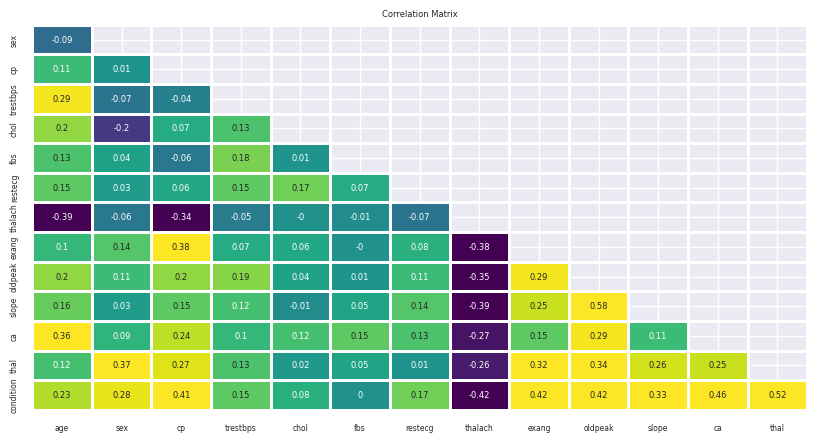

In [13]:
correlation_values(df)

1.   Entre as características com correlação positiva mais alta; thal, ca, oldpeak, exang, cp; (0,52, 0,46, 0,42, 0,41)
2.   Apenas uma característica possui correlação negativa com a variável alvo; thalach (-0,42)
3. A única característica que possui pouca ou nenhuma correlação linear com a variável alvo é fbs (0,0)



### Divisão Valores Categóricos e Numéricos

In [14]:
df.nunique()

age           41
sex            2
cp             4
trestbps      50
chol         152
fbs            2
restecg        3
thalach       91
exang          2
oldpeak       40
slope          3
ca             4
thal           3
condition      2
dtype: int64

*   Numericos: age,oldpeak,trestbps,thalach,chol
*   Categóricos: sex,restecg,slope,fbs,cp,exang,thal,ca



In [15]:
cat_features = ['sex','restecg','slope','fbs','cp','exang','thal','ca']
num_features = ['age', 'oldpeak', 'trestbps', 'thalach', 'chol']

# para fazer algumas distribuições com o target/condition

cat_features_target = ['sex','restecg','slope','fbs','cp','exang','thal','ca','condition']

#### Gráficos sobre as Distruições dos Dados e Geração de Insights

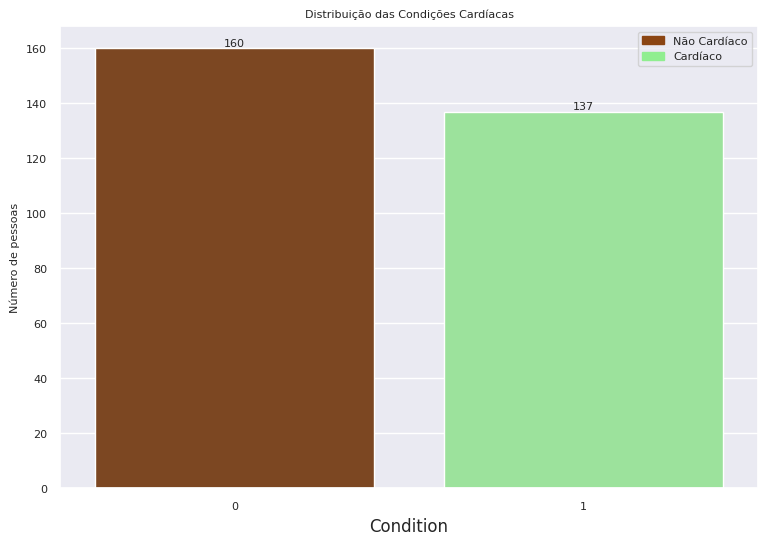

In [16]:
plt.figure(figsize=(9, 6))
sns.barplot(x=df['condition'].value_counts().index, y=df['condition'].value_counts(), palette=custom_palette)

plt.xlabel("Condition", fontsize=12)
plt.ylabel("Número de pessoas", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

for i, count in enumerate(df['condition'].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=8)

plt.title("Distribuição das Condições Cardíacas", fontsize=8)

# Atualizando a legenda
legend_labels = ['Não Cardíaco', 'Cardíaco']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in custom_palette]
plt.legend(legend_handles, legend_labels, fontsize=8)

plt.show()

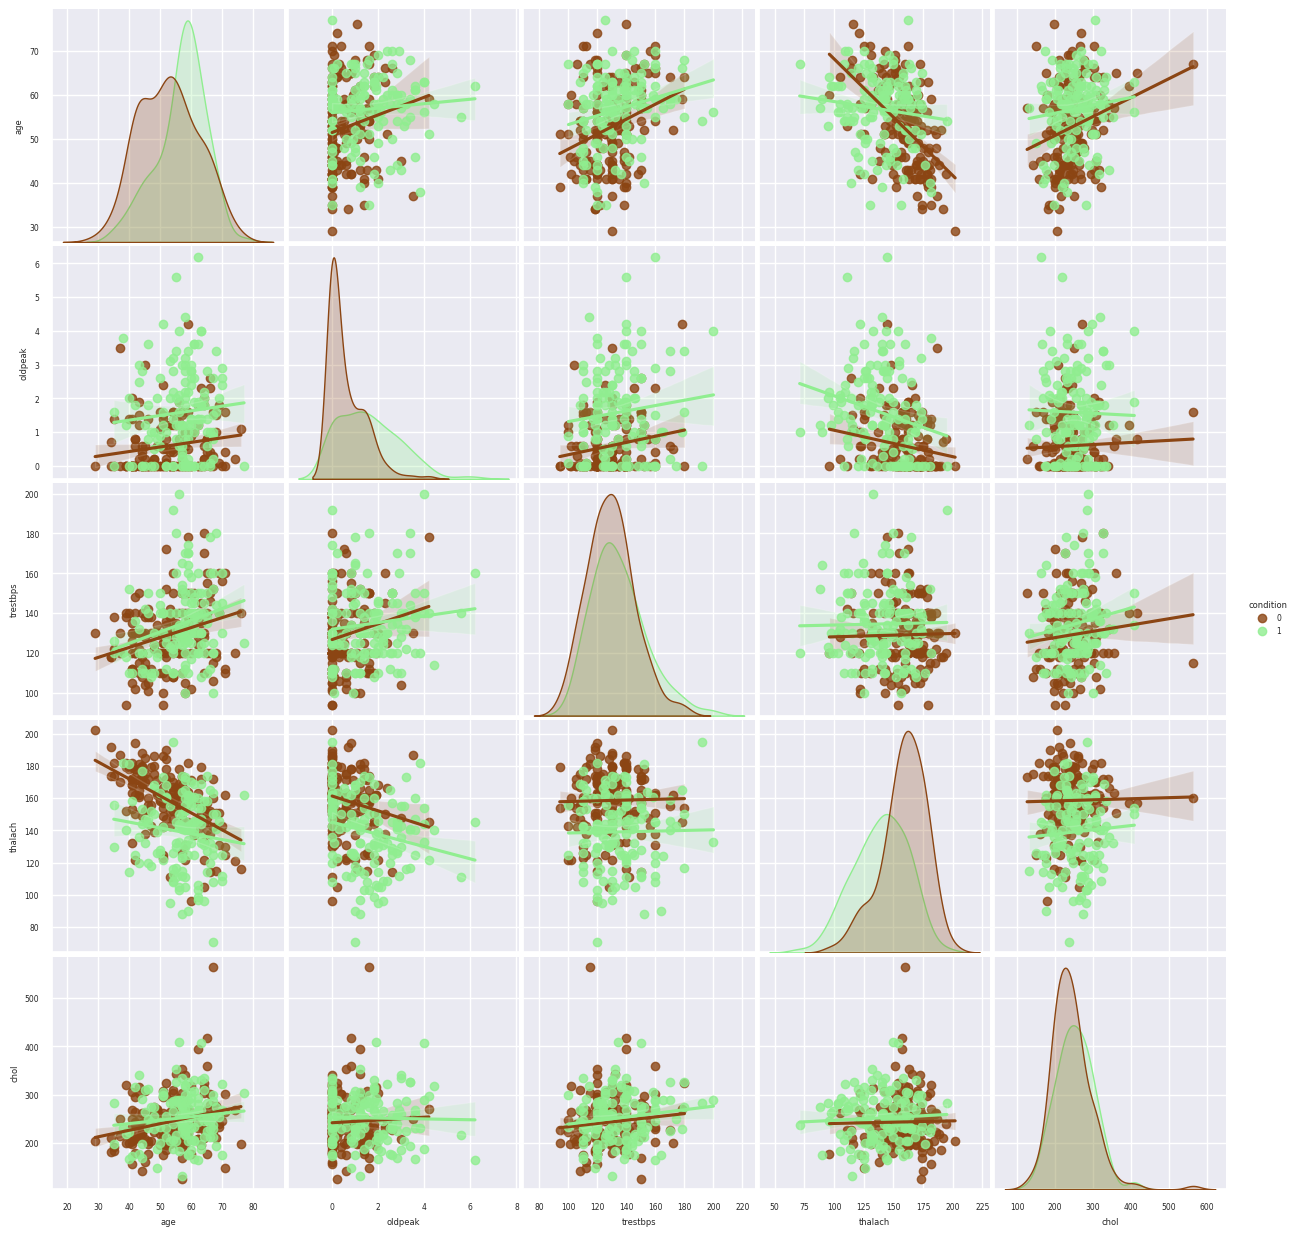

In [17]:
sns.pairplot(df, hue='condition', vars=num_features,kind='reg')
plt.show()

#### Análise sobre os Valores Categóricos frente ao Target

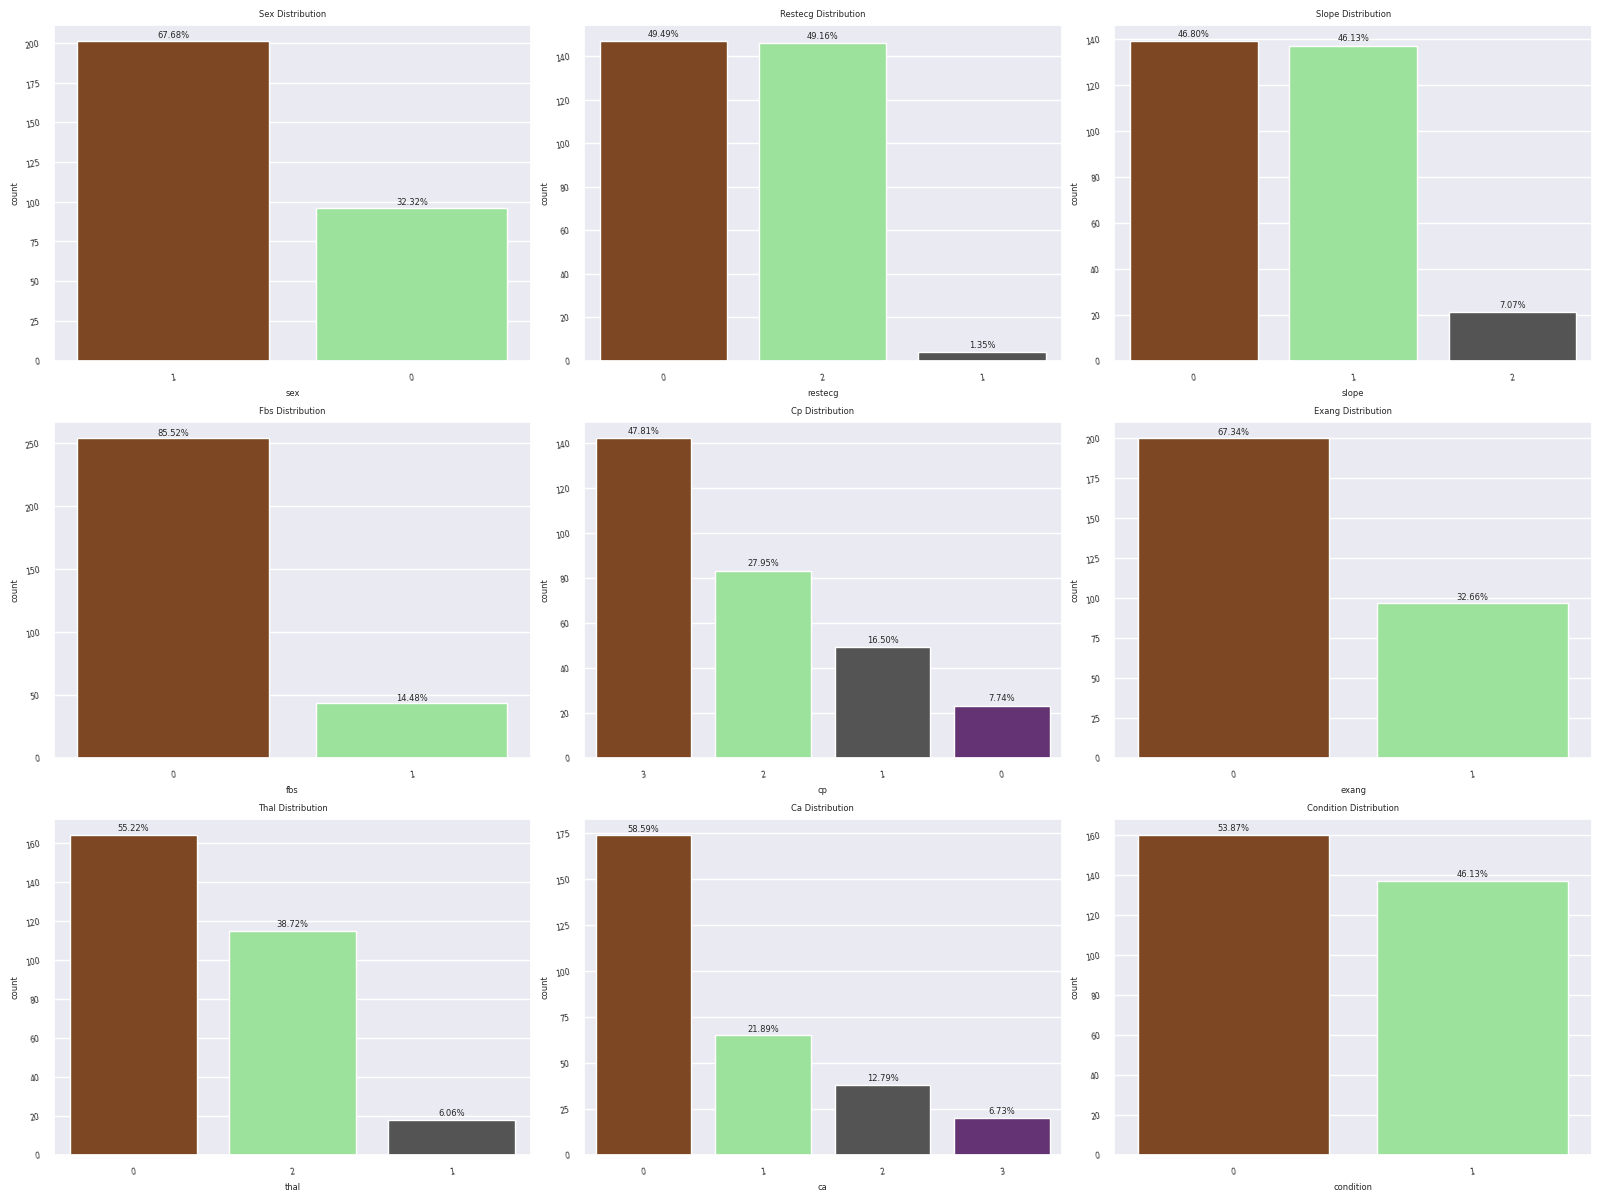

In [78]:
cat_dist(df, cat_features_target,hue=None, rows=3,columns=3)

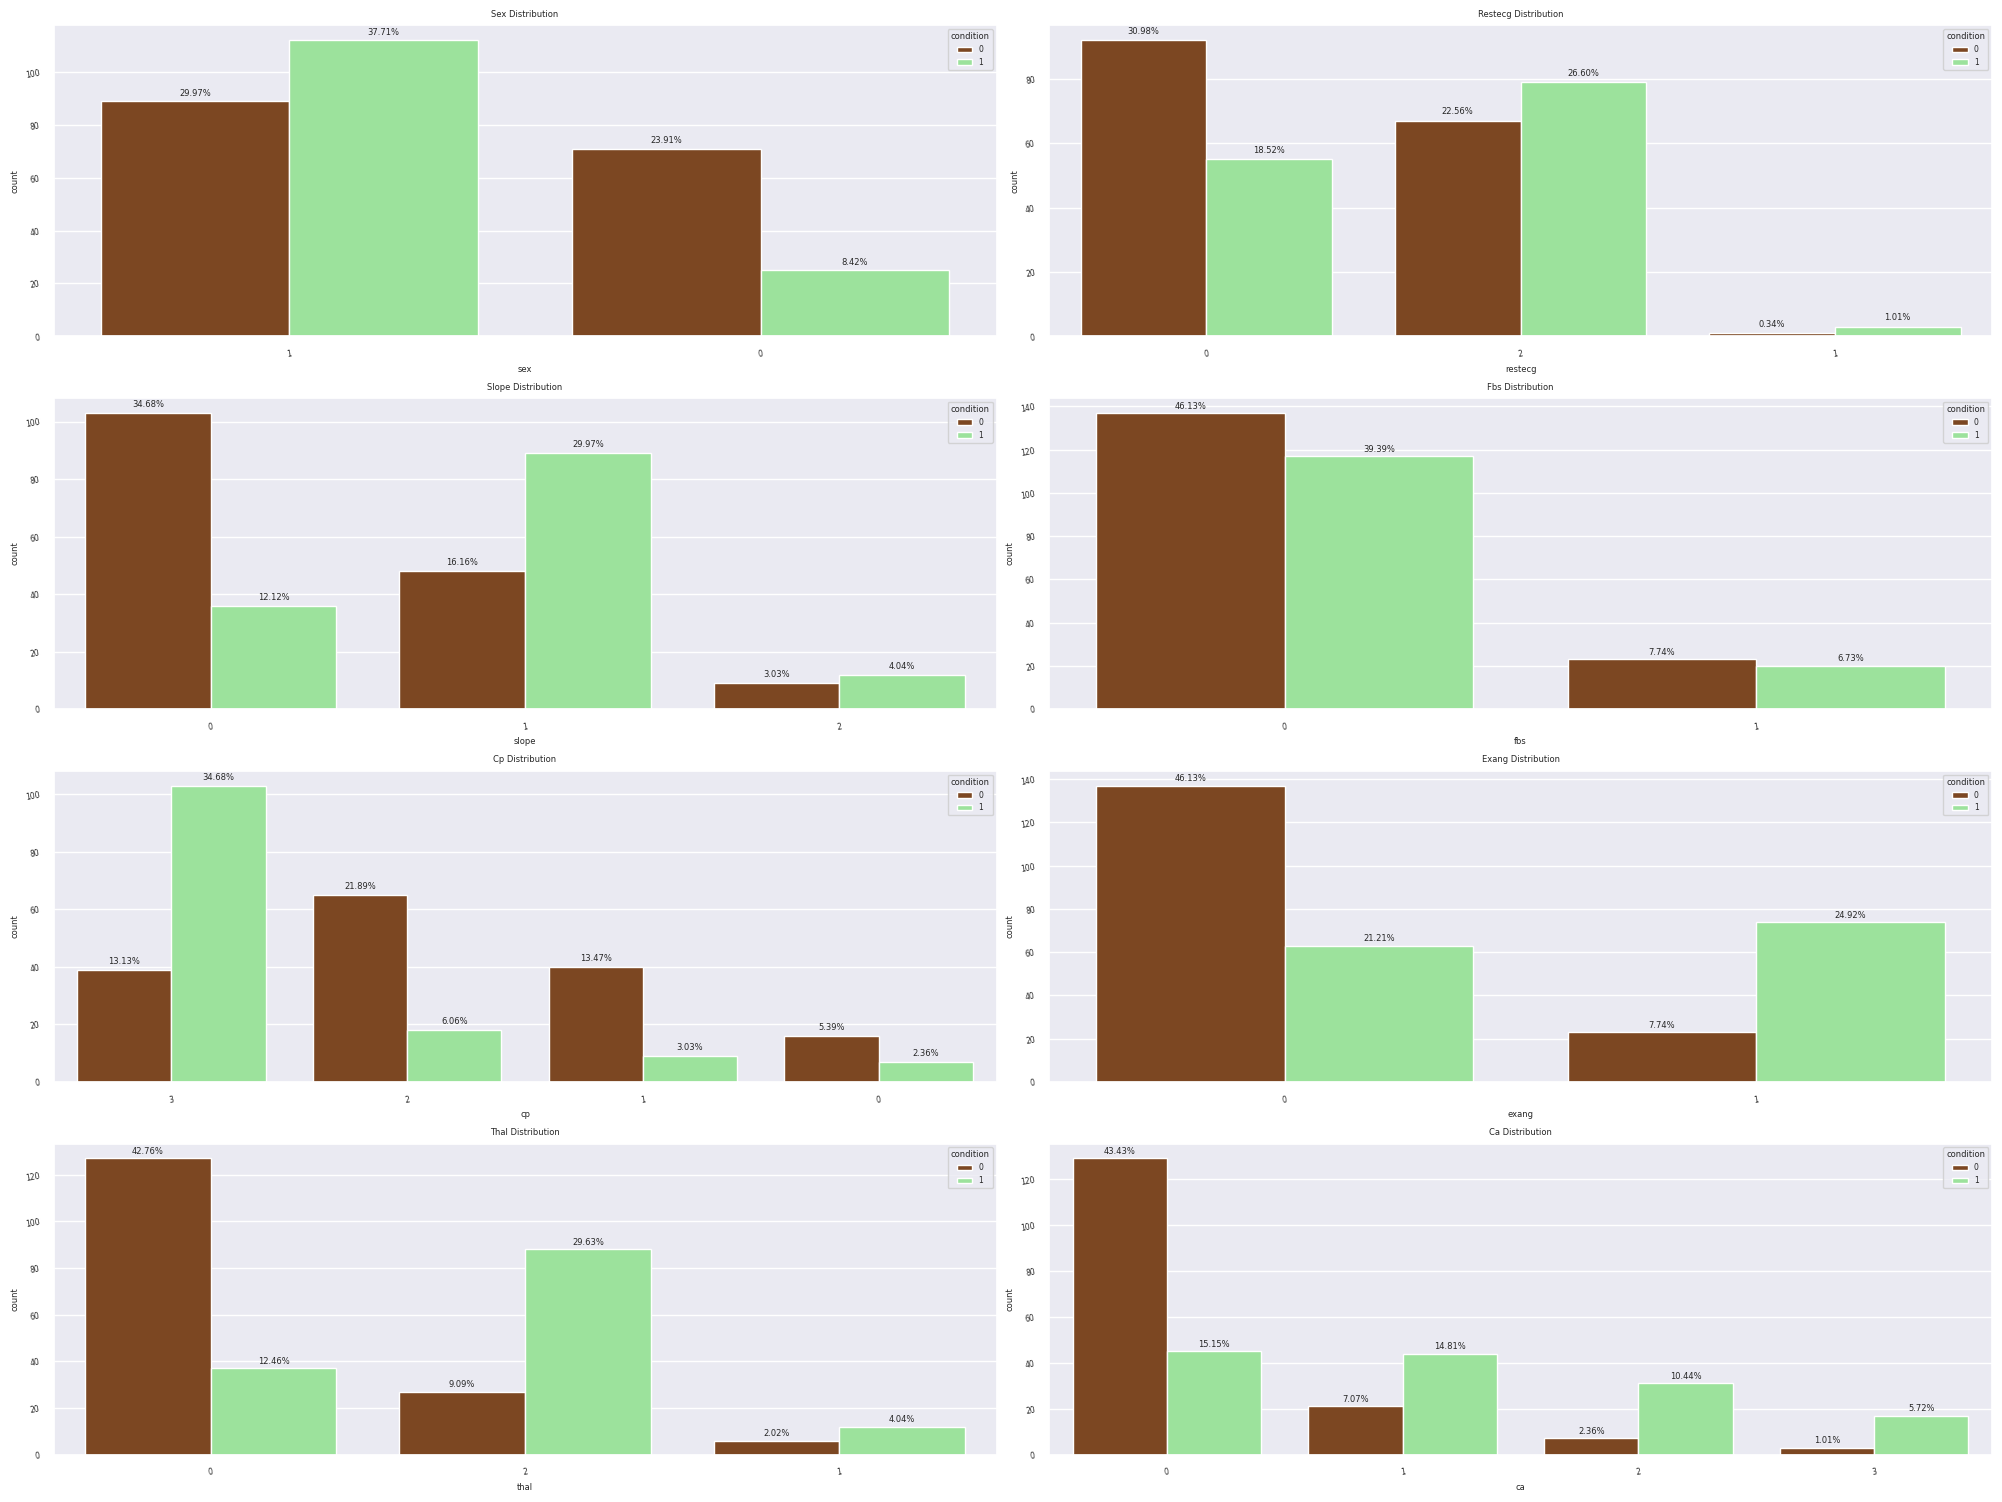

In [79]:
cat_dist2(df, cat_features_target, 4, 2)

Dos gráficos mostrados acima sobre os dados categóricos, pode-se observar:



1.   Os homens têm uma probabilidade muito maior de terem doenças cardíacas.
3. O nível de açúcar no sangue (fbs) não tem efeito direto na doença.
4. Resultados de ECG em repouso (restecg) não apresentam resultados diretos, mas ter um ECG normal é um sinal bastante positivo. Embora seja bastante raro nos dados, se houver anormalidade na onda ST-T, a probabilidade de ter doença cardíaca é três vezes maior.
5. exang = True é um indicador bastante forte de doença cardíaca, os pacientes têm quase três vezes mais chances de ter doença se tiverem angina induzida por exercício (exang). Enquanto isso, a probabilidade é menos da metade para aqueles que não têm.
6. Pacientes com distribuição de inclinação plana (slope = 1) têm maior probabilidade de ter doença.
7. O número de vasos principais observados (ca) parece estar em níveis semelhantes para pacientes com doença, mas não ter observações (0) é um bom sinal de que não há doença.
9. Em geral, pacientes com doenças cardíacas apresentam esse padrão: são mais velhos, tem um alto trestbps, colesterol alto, oldpeak alto e um baixo thalach.







#### Análise sobre os Valores Numéricos frente ao Target

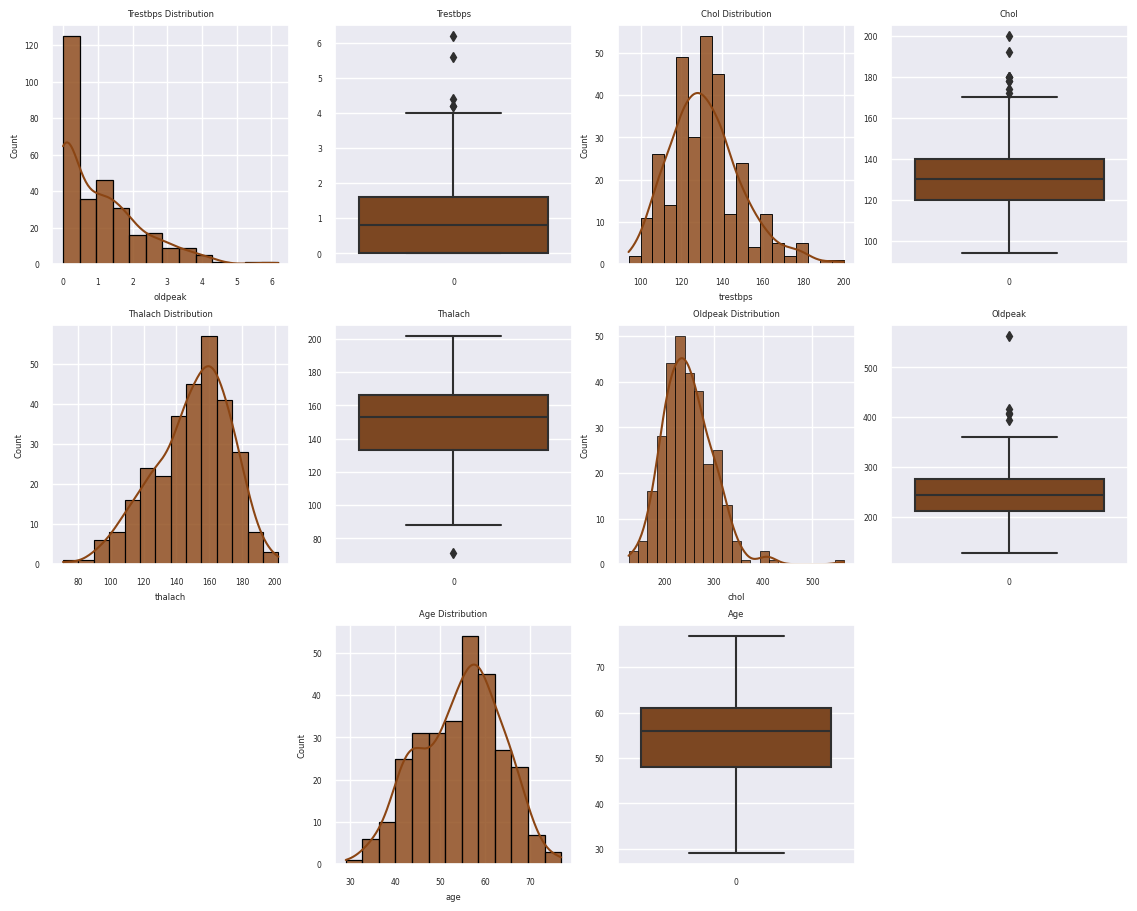

In [80]:
num_dist(df, num_features)

Dos gráficos mostrados acima sobre os dados numéricos, pode-se observar:

1.   Ter uma pressão arterial em repouso (trestbps) mais alta indica uma pequena probabilidade de ter doença cardíaca.
4. A probabilidade de doença cardíaca aumenta com os níveis de depressão do segmento ST (oldpeak)
5. Pacientes mais idosos têm maior probabilidade de ter doença cardíaca.



## Conclusão do EDA e Pre-processamento

No geral, o que será tirado dessa análise toda é isso:



*   Em geral, pacientes com doenças cardíacas apresentam esse padrão: são mais velhos, tem um alto trestbps, colesterol alto, oldpeak alto e um baixo thalach.
*   fbs será retirado do dataset, pois não tem uma alta influência no target.

### Pre-processamento: Usando OneHotEncoder (get dummies do pandas)

In [18]:
# Retirado fbs
cat_features = ['sex','restecg','slope','cp','exang','thal','ca']
num_features = ['age', 'oldpeak', 'trestbps', 'thalach', 'chol']

In [23]:
df.drop('fbs', axis = 1, inplace = True)

In [25]:
df[cat_features].nunique().sum()

21

In [26]:
dummy_variables = dummy(df, cat_features)
df = pd.concat([df] + dummy_variables, axis=1)
df = df.drop(cat_features, axis=1)

In [27]:
df

,age,trestbps,chol,thalach,oldpeak,condition,sex_0,sex_1,restecg_0,restecg_1,...,cp_3,exang_0,exang_1,thal_0,thal_1,thal_2,ca_0,ca_1,ca_2,ca_3
0,69,160,234,131,0.1,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
1,69,140,239,151,1.8,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,66,150,226,114,2.6,0,1,0,1,0,...,0,1,0,1,0,0,1,0,0,0
3,65,138,282,174,1.4,1,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
4,64,110,211,144,1.8,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,152,223,181,0.0,1,0,1,1,0,...,1,1,0,0,0,1,1,0,0,0
293,39,118,219,140,1.2,1,0,1,1,0,...,1,1,0,0,0,1,1,0,0,0
294,35,120,198,130,1.6,1,0,1,1,0,...,1,0,1,0,0,1,1,0,0,0
295,35,138,183,182,1.4,0,1,0,1,0,...,1,1,0,1,0,0,1,0,0,0


## Construção dos Modelos de Classificação

### Divisão Treino e Teste

In [28]:
y = df['condition']
X = df.drop('condition', axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [30]:
print(f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

X_train: (207, 26) 
X_test: (90, 26) 
y_train: (207,) 
y_test: (90,)


## Avaliação dos Modelos

### Execução dos Classificadores em Bloco

Os dados estão sendo **normalizados** dentro do método *'evaluate_models'*


*   Dados divididos entre treino e teste
*   Normalização
*   GridSearchCV (GridSearch + KFold CV)
*   Testes com melhores parâmetros
*   Tempo de Execução




### Justificativa de escolha dos modelos

Como o dataset é pequeno e temos conhecimento de algoritmos de classificação que já foram abordados em outros trabalhos, a implementação fica mais fácil e a cobertura de classificação para observações fica mais ampla. Dessa forma, ao invés de simplesmente usar somente 3 algoritmos, no projeto foram usados 6.

Dentre eles estão: SVM, Árvore de Decisão (Decision Tree), KNN, Floresta Aleatória (Random Forest), Regressão Logística e MLP. Porém, abaixo vou explicar os 3 algoritmos que eu escolheria caso fosse necessário fazer somente com 3, pois existem alguns que já sabe que não será uma boa escolha por conta do dataset e dos objetivos.



1.   **Regressão Logística**: Comumente utilizado em classificações binárias, que é o caso do nosso target, classificação entre cardíacos e não cardíacos. Normalmente é um algoritmo rápido que utiliza a relação entre variáveis independentes e a probabilidade de pertencer a uma classe específica 0 ou 1.

2.   **KNN**: É um algoritmo muito utilizado e amplo no seu contexto, então ele é um bom algoritmo para se testar em praticamente todos os datasets. Ele utiliza o sistema de distância entre a amostra de teste e as amostras de treino e o conceito de 'k-vizinhos' é aplkicado para serem selecionados a partir dessa distância, fazendo a atribuição para a classificação.

3. **MLP**: O uso do MLP foi para entender e mostrar o funcionamento da rede neural artificial no dataset. Com o uso do GridSearch para encontrar os melhores hiperparâmetros, a ideia é saber se o algoritmo se ajusta bem aos dados e consegue fazer uma classificação efetiva mesmo que não exija de tanta complexidade.





#### Resultados com MinMaxScaler

Com divisão 70/30

In [43]:
results_df = evaluate_models(X_train, X_test, y_train, y_test, standardscaler = False)
print(results_df)

         Classificador  Acurácia  Precisão  F1 Score   ROC/AUC      Tempo  \
0                  SVM  0.822222  0.809524  0.809524  0.821429   0.198149   
1        Decision Tree  0.744444  0.711111  0.735632  0.745536   0.277865   
2                  KNN  0.855556  0.822222  0.850575  0.857143   0.273163   
3        Random Forest  0.811111  0.790698  0.800000  0.811012  15.327129   
4  Logistic Regression  0.822222  0.770833  0.822222  0.825893   0.424917   
5                  MLP  0.844444  0.818182  0.837209  0.845238  31.357806   

                                     Best Parameters  
0                        {'C': 0.1, 'kernel': 'rbf'}  
1           {'max_depth': 1, 'min_samples_split': 2}  
2           {'n_neighbors': 5, 'weights': 'uniform'}  
3             {'max_depth': 10, 'n_estimators': 100}  
4                         {'C': 1, 'solver': 'saga'}  
5  {'alpha': 0.001, 'hidden_layer_sizes': (100, 50)}  


#### Resultados com StandardScaler

Com divisão 70/30

In [46]:
results_df = evaluate_models(X_train, X_test, y_train, y_test)
print(results_df)

         Classificador  Acurácia  Precisão  F1 Score   ROC/AUC      Tempo  \
0                  SVM  0.844444  0.818182  0.837209  0.845238   0.332336   
1        Decision Tree  0.744444  0.711111  0.735632  0.745536   0.279206   
2                  KNN  0.844444  0.833333  0.833333  0.843750   0.253798   
3        Random Forest  0.777778  0.739130  0.772727  0.779762  15.977390   
4  Logistic Regression  0.844444  0.804348  0.840909  0.846726   1.671257   
5                  MLP  0.777778  0.750000  0.767442  0.778274  30.368083   

                                   Best Parameters  
0                   {'C': 0.5, 'kernel': 'linear'}  
1         {'max_depth': 1, 'min_samples_split': 2}  
2       {'n_neighbors': 10, 'weights': 'distance'}  
3            {'max_depth': 5, 'n_estimators': 200}  
4                {'C': 0.1, 'solver': 'liblinear'}  
5  {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}  


## Conclusão

É importante mencionar que foi utilizado o StratifiedKFold com cv = 4 pois o StratifiedKFold é uma boa validação cruzada para datasets pequenos, que é o caso.

Também importante mencionar que foram testadas diversas divisões de treino/teste e as melhores métricas retornadas foram com a divisão 70/30, fazendo testes cíclicos com as normalizações MinMaxScaler e StandardScaler.

Sobre os resultados dos modelos, é importante mencionar que nosso *'chute'* sobre os algoritmos foram acertivos, pois KNN e LogisticRegression apresentaram-se os melhores classificadores para esse conjunto de dados, com o MLP ligeiramente atrás com um tempo relativamente alto de execução.

Como mencionado anteriormente, os algoritmos KNN e LogisticRegression são bons algoritmos para classificação binária, são relativamente rápidos e conseguem normalmente fazer uma classificação boa quando utilizado o GridSearch para encontrar os melhores parâmetros. No caso, o KNN foi ligeiramente melhor pois ele é um classificador mais flexível e mais complexo, garantindo uma maior cobertura dos dados e fazendo suposições mais acertivas. Já o MLP era sabido que provavelmente não seria o melhor modelo no caso, porém teve boas métricas, pois sabe-se que o dataset não era tão complexo assim e o uso de rede neural ia aumentar bastante o contexto do tempo e isso se provou.



## Análise do Melhor Modelo (KNN)

In [47]:
y = df['condition']
X = df.drop('condition', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [48]:
params = {'n_neighbors': 5, 'weights': 'uniform'}
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(**params)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("accuracy", accuracy)
print("f1", f1)
print("precision", precision)
print("roc_auc", roc_auc)

accuracy 0.8555555555555555
f1 0.8505747126436781
precision 0.8222222222222222
roc_auc 0.8571428571428571


In [49]:
plot_confusion_matrix(model, y_pred, y_test)

In [39]:
y_test = np.array(list(y_test))
y_pred = np.array(y_pred)
df_final = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_pred.flatten()})
df_final

,Actual,Predicted
0,1,1
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
85,0,0
86,1,1
87,1,1
88,1,1
